![movieset](movie_set.png)

# Microsoft's Next Move

**Deanna Gould**
***

## Overview

This project is going to go help solve some questions for Microsoft as they start entering the realm of movie production. Since Microsoft hasn't been in the entertainment business in such a way before, Microsoft's executives need to know what is most important in creating a successful movie in order to properly allocate resources. 

The data that I use in this analysis is IMDB data in CSV files. In this analysis, I explore the DataFrames and learn what the DataFrame includes and what some limitations are. Afterward, I clean the data to make sure everything is in proper format, the data types necessary to perform the analysis, and when preparing the data, I start to merge the DataFrames into one. After I've merged everything, I remove anything that isn't needed, and I look at maximum and minimum correlation, as well as plotting some graphs. 

The results were very telling. When comparing genres to worldwide gross, Action earned the most revenue by a considerable amount, followed by Adventure. I then compared directors and sorted directors by worldwide gross as well as rating. This gave lots of insight into which directors have the highest gross, along with their average rating. In addition to that, I compared production budget to worldwide gross. In order to have a successful movie, I would recommend that the movie be an Action movie, with a production budget of at least 2 million, directed by Gail Cronauer or Neil Ruddock.

***

## Business Problem

Microsoft hasn't created any movies yet, and needs three solid recommendations of what to focus resources on. In my experience, some of the best movies had famous directors and extremely expensive budgets, but I also wanted to know if it mattered what genre a movie was. In this analysis, I'm measuring success by worldwide gross and average rating, because Microsoft should be concerned about their ROI along with what people think of the movie. From a business perspective, Microsoft's first movie will be remembered by many, an in order to be taken seriously in the entertainment industry, it will need to be known around the world, as well as having good ratings.


***

## Data Understanding

In [565]:
# Importing standard packages needed for the notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [566]:
# Here I'm importing the CSV's and creating dataframes for the files, and also establishing my connection for SQLite.

mvs = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col=0)
budg = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', index_col=0)
inf = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t', index_col=0)
conn = sqlite3.connect('zippedData/im.db')
basics = pd.read_sql("""SELECT * FROM movie_basics;""", conn)
ratings = pd.read_sql("""SELECT * FROM movie_ratings;""", conn)
mdir = pd.read_sql("""SELECT * FROM directors;""", conn)
ppl = pd.read_sql("""SELECT * FROM persons;""", conn)

### *Creating a function to recycle in Data Understanding*

This function was found in one of the Github Repositories for this project written by Erin Hoffman which can be found here: [Repository Readability](https://github.com/learn-co-curriculum/dsc-repo-readability-v2-2).

In [567]:
# This function will save some time when learning about the key features of the DataFrames

def summarize_data(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Duplicates'] = df.duplicated().sum()

    return summary 

**Understanding the basics DataFrame**

First I'm going to run this DataFrame through the function I created and see if anything stands out to me.

In [568]:
summarize_data(basics)

,Name,dtypes,Missing,Uniques,Duplicates
0,movie_id,object,0,146144,0
1,primary_title,object,0,136071,0
2,original_title,object,21,137773,0
3,start_year,int64,0,19,0
4,runtime_minutes,float64,31739,367,0
5,genres,object,5408,1085,0


In the basics DataFrame, movie_id is going to be my primary key. I might need to join on the movie name later on in the analysis, so it's important to note that original_title has null values while primary_title does not. Since ethere are no missing values, and all are unique, I know I can use this for a primary key.

I'm also going to pay attention to genre and look into the genres field more in depth later. Running `basics.head()` below will give me an idea of what the values will look like.

In [569]:
basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


Now that I know what some of the values look like, I know why genres might have been appearing with so many unique values in my original summary. I will have to separate the genres later, but will do that after I merge my DataFrames.

**Understanding the ratings DataFrame**

To start, I'm also going to run the ratings DataFrame through my summarize function.

In [570]:
summarize_data(ratings)

,Name,dtypes,Missing,Uniques,Duplicates
0,movie_id,object,0,73856,0
1,averagerating,float64,0,91,0
2,numvotes,int64,0,7349,0


In this DataFrame, I'm looking to use averagerating in my analysis, and I will need to join on movie_id, but I won't need the numvotes column. As expected, averagerating and numvotes are float64 and int64, while movie_id is a string and can't be aggregated.

Since there's no missing values, I can use movie_id as a primary key for this DataFrame as well. It's not necessary for me to use `df.describe` for every DataFrame, but I am going to use it for the ratings DataFrame because I'm using the numerical values within this DataFrame. 

In [571]:
ratings.describe()

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


It's interesting that numvotes is appearing in scientific notation, but I'm not going to worry about it since I won't be using it in my analysis. Based on running `ratings.describe`, I can tell that the median is 6.5 and the mean is 6.33. The top quartile is 7.4 and above, which I think is what Microsoft should be aiming for.

**Understanding the mdir DataFrame**

Similar to what I did before, I'm going to run this mdir DataFrame through the summarize function created in the beginning.

In [572]:
summarize_data(mdir)

,Name,dtypes,Missing,Uniques,Duplicates
0,movie_id,object,0,140417,127639
1,person_id,object,0,109253,127639


Both movie_id and person_id should be unique identifiers because they're id's, but there are duplicates, so I'm going to remove them now.

In [573]:
mdir.drop_duplicates(inplace=True)

Now I'm going to make sure that applied to my DataFrame.

In [574]:
print(mdir.duplicated().sum())

0


I typically like to look at each the head of each DataFrame to have a visual understanding, but it's not necessary with this DataFrame because of what it consists of.

**Understanding the ppl DataFrame**

I'm going to run this DataFrame through the summarize function as well.

In [575]:
summarize_data(ppl)

,Name,dtypes,Missing,Uniques,Duplicates
0,person_id,object,0,606648,0
1,primary_name,object,0,577203,0
2,birth_year,float64,523912,267,0
3,death_year,float64,599865,214,0
4,primary_profession,object,51340,8647,0


In this DataFrame, I'm going to need person_id which I will use as a primary key to join on later. I won't need birth_year or death_year, so I'm not concerned about the missing values in those columns. I'm also not concerned about the missing values in primary_profession, because I already know which person_id's are directors.

I'm going to continue going through some of the basics to explore this DataFrame, and look at `ppl.head()` so I know what the DataFrame looks like.

In [576]:
ppl.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


As a reminder, I'm only going to be using person_id and primary_name from this DataFrame.

**Understanding the budg DataFrame**

Like the other DataFrames, I'm going to run this through the summarize function to get a quick look about all the necessary information.

In [577]:
summarize_data(budg)

,Name,dtypes,Missing,Uniques,Duplicates
0,release_date,object,0,2418,0
1,movie,object,0,5698,0
2,production_budget,object,0,509,0
3,domestic_gross,object,0,5164,0
4,worldwide_gross,object,0,5356,0


It's great to see that there aren't any null values in the DataFrame, but I wasn't expecting production_budget, domestic_gross, or worldwide_gross to be objects instead of a float or an int datatype. It's also surprising release_date isn't a datetime datatype, but I won't be needing that in my analysis.

Taking a look at the first few rows of the budg DataFrame to get an understanding of what it looks like. 

In [578]:
budg.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


Normally I would want to run `budg.describe` to get a greater statistical understanding of the DataFrame, but since none of the fields are int or floats yet, it won't work the way I want it to.

***

## Data Preparation

**Cleaning and Merging DataFrames**

I'm going to continue moving through my data in the same way that I imported it. For the first few DataFrames (basics, ratings, mdir, and ppl) I'm going to merge them first, and then clean what is needed. There aren't a lot of columns, and the unique identifiers are very clear.

First, I want to merge mdir and ppl together. I'd like to have a primary_name for every person_id. Before I make any joins, I'm going to run `mdir.shape` and `ppl.shape` to remind myself how much data is in each DataFrame, and compare it to the shape after I merge the DataFrame.

In [579]:
mdir.shape

(163535, 2)

In [580]:
ppl.shape

(606648, 5)

That is a lot of data in both of these DataFrames, and I'm not going to need all of it.

In [581]:
# I want to make sure I'm joining on person_id and I'm doing a left join so I get primary_name for person_id's in
# the mdir DataFrame
dirppl = mdir.merge(ppl, how="left", on='person_id')
dirppl

,movie_id,person_id,primary_name,birth_year,death_year,primary_profession
0,tt0285252,nm0899854,Tony Vitale,1964.0,NaN,"producer,director,writer"
1,tt0462036,nm1940585,Bill Haley,NaN,NaN,"director,writer,producer"
2,tt0835418,nm0151540,Jay Chandrasekhar,1968.0,NaN,"director,actor,writer"
3,tt0878654,nm0089502,Albert Pyun,1954.0,NaN,"director,writer,producer"
4,tt0878654,nm2291498,Joe Baile,NaN,NaN,"producer,director,camera_department"
...,...,...,...,...,...,...
163530,tt8999974,nm10122357,Daysi Burbano,NaN,NaN,"director,writer,cinematographer"
163531,tt9001390,nm6711477,Bernard Lessa,NaN,NaN,"director,writer,cinematographer"
163532,tt9001494,nm10123242,Tate Nova,NaN,NaN,"director,producer"
163533,tt9001494,nm10123248,Courtney Faye Powell,NaN,NaN,"director,producer"


In [582]:
# Checking for duplicates after the merge
print(dirppl.duplicated().sum(),' duplicates')

0  duplicates


In [583]:
# Checking for null values after the merge
dirppl.isna().any()

movie_id              False
person_id             False
primary_name           True
birth_year             True
death_year             True
primary_profession     True
dtype: bool

There are some null values in the DataFrame, but nothing that is surprising.

Since I only want some of these columns, specifically movie_id, person_id, and primary_name, I'm going to drop some of the other columns that I don't need for my analysis.

In [584]:
dirppl.drop(['death_year', 'birth_year'], axis=1, inplace=True)

Checking the DataFrame with `dirppl.head` after I've dropped the unnecessary columns to see what it looks like.

In [585]:
dirppl.head()

,movie_id,person_id,primary_name,primary_profession
0,tt0285252,nm0899854,Tony Vitale,"producer,director,writer"
1,tt0462036,nm1940585,Bill Haley,"director,writer,producer"
2,tt0835418,nm0151540,Jay Chandrasekhar,"director,actor,writer"
3,tt0878654,nm0089502,Albert Pyun,"director,writer,producer"
4,tt0878654,nm2291498,Joe Baile,"producer,director,camera_department"


Now that this DataFrame looks good, I'm going to join the basics DataFrame with the ratings DataFrame. Before I make the join, I'm going to check the shape of each DataFrame first with `basics.shape` and `ratings.shape`.

In [586]:
basics.shape

(146144, 6)

In [587]:
ratings.shape

(73856, 3)

In [588]:
# This merge is going to be an inner join because I want to get only data that exists in both DataFrames.
basrat = basics.merge(ratings, how="inner", on="movie_id")
basrat

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,6.6,5


In [589]:
# Checking if any duplicates were created during the merge
print(basrat.duplicated().sum())

0


In [590]:
# Checking which columns have null values
basrat.isna().any()

movie_id           False
primary_title      False
original_title     False
start_year         False
runtime_minutes     True
genres              True
averagerating      False
numvotes           False
dtype: bool

With this joined, I'm going to drop some of the columns that I don't need for my analysis.

In [591]:
basrat.drop(['start_year', 'runtime_minutes', 'numvotes'], axis=1, inplace=True)
basrat

,movie_id,primary_title,original_title,genres,averagerating
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama",7.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama",7.2
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama,6.9
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama",6.1
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy",6.5
...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,Documentary,6.2
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,"Drama,Family",8.7
73853,tt9914642,Albatross,Albatross,Documentary,8.5
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,None,6.6


There are 73856 rows in my new basrat DataFrame, so I know that the merge was done properly.

Now, I can join these two DataFrames together that I just created (dirppl and basrat), and then create a new variable for that DataFrame as well. Before I join, I want to remind myself how big the basrat DataFrame is with `dirppl.shape` again.

In [592]:
basrat.head()

,movie_id,primary_title,original_title,genres,averagerating
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama",7.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama",7.2
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama,6.9
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama",6.1
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy",6.5


In [593]:
dirppl.shape

(163535, 4)

In [594]:
dirppl.isna().any()

movie_id              False
person_id             False
primary_name           True
primary_profession     True
dtype: bool

In [595]:
dirppl.head()

,movie_id,person_id,primary_name,primary_profession
0,tt0285252,nm0899854,Tony Vitale,"producer,director,writer"
1,tt0462036,nm1940585,Bill Haley,"director,writer,producer"
2,tt0835418,nm0151540,Jay Chandrasekhar,"director,actor,writer"
3,tt0878654,nm0089502,Albert Pyun,"director,writer,producer"
4,tt0878654,nm2291498,Joe Baile,"producer,director,camera_department"


In [596]:
# Delete this later, this is showing that there are a few different titles named Avatar
basrat.loc[basrat['primary_title']=="Avatar"]

,movie_id,primary_title,original_title,genres,averagerating
9944,tt1775309,Avatar,Abatâ,Horror,6.1


In [597]:
df1 = basrat.merge(dirppl, how="inner", on="movie_id")
df1

,movie_id,primary_title,original_title,genres,averagerating,person_id,primary_name,primary_profession
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama",7.0,nm0712540,Harnam Singh Rawail,"director,writer,producer"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama",7.2,nm0002411,Mani Kaul,"director,writer,actor"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama,6.9,nm0000080,Orson Welles,"actor,director,writer"
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama",6.1,nm0611531,Hrishikesh Mukherjee,"director,editor,writer"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy",6.5,nm0765384,Valeria Sarmiento,"editor,director,writer"
...,...,...,...,...,...,...,...,...
86026,tt9913084,Diabolik sono io,Diabolik sono io,Documentary,6.2,nm0812850,Giancarlo Soldi,"director,writer,producer"
86027,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,"Drama,Family",8.7,nm4394529,Ahmet Faik Akinci,"director,writer"
86028,tt9914642,Albatross,Albatross,Documentary,8.5,nm5300859,Chris Jordan,"director,writer,editor"
86029,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,None,6.6,nm1716653,Laura Jou,"miscellaneous,actress,director"


I was expecting there to be 73856 rows in the df1 DataFrame, and since there are more, I'm going to check for null values and duplicates that could've occurred due to the merge.

In [598]:
df1.duplicated().sum()

0

No duplicates, but maybe there are some more null values.

In [599]:
df1.isna().sum()

movie_id                0
primary_title           0
original_title          0
genres                798
averagerating           0
person_id               0
primary_name            1
primary_profession     90
dtype: int64

There aren't as many null values as I was expecting, but I'm glad to know there aren't as many nulls or any duplicates.

**Cleaning the Budget DataFrame**

Taking a quick look at what the Budget DataFrame looks like again to see what the data looks like.

In [600]:
budg.head(1)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


Since all of the columns are object data type, I will need to clean the data and change the data type in order to use production_budget or worldwide_gross in my analysis. First I will remove the dollar signs.

In [601]:
# Removing $ signs
budg['production_budget'] = budg['production_budget'].str.replace('$', '')

Now that the dollar signs have been removed, I'm also going to remove the commas from the column.

In [602]:
# Using replace to get rid of commas
budg['production_budget'] = budg['production_budget'].str.replace(',','')

Now that the dollar signs and commas have been removed, I'm able to change the object data type to int.

In [603]:
#Changing the data type to int
budg['production_budget'] = budg['production_budget'].astype(int)

With those steps done, I'm going to take another look at what the column looks like now.

In [604]:
budg['production_budget'][1].head()

id
1    425000000
1    175000000
1    145000000
1    120000000
1    100000000
Name: production_budget, dtype: int64

Since I'm using the worldwide_gross column to measure the success of a movie, I will need to clean up that column as well.

In [605]:
# Removing $ signs
budg['worldwide_gross'] = budg['worldwide_gross'].str.replace('$','')

Now that I've removed the dollar sign, I'm also going to remove the commas.

In [606]:
# Following same method to remove commas
budg['worldwide_gross'] = budg['worldwide_gross'].str.replace(',','')

Now that I've removed those, I can now change the object data type to int data type for further analysis.

In [607]:
# Changing data type to int
budg['worldwide_gross'] = budg['worldwide_gross'].astype(int)

Since we're already here, I'm going to clean up the domestic_gross column as well just in case I would like to use it in my analysis.

In [608]:
# Replacing the $ signs
budg['domestic_gross'] = budg['domestic_gross'].str.replace('$', '')

In [609]:
# Replacing the commas
budg['domestic_gross'] = budg['domestic_gross'].str.replace(',','')

In [610]:
# Changing the data type to an int
budg['domestic_gross'] = budg['domestic_gross'].astype(int)

In [611]:
# Creating a new column with net profit for each film
budg['net_profit'] = budg['worldwide_gross'] - budg['production_budget']

In [612]:
# Changing the datatype to int
budg['net_profit'] = budg['net_profit'].astype(int)

A quick look at what the budg DataFrame looks like now with those changes made.

In [613]:
budg.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_profit
id,,,,,,
1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650
4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747


Now that the budg DataFrame is cleaned and looks good, I'm going to merge it into df1.

**Merging DataFrames Again**

To do my analysis, I'm going to need to join budg to the df1 DataFrame, and then I will clean up the genre column. I'm going to take another look at how many rows are in each DataFrame, so I know can verify how much data I lost or gained due to my join. 

In [614]:
budg.shape

(5782, 6)

In [615]:
df1.shape

(86031, 8)

The df1 DataFrame is significantly larger than the budg DataFrame. I would like to only keep data where budg and df1 match on original_title

In [616]:
df1.rename(columns={'original_title':'movie'}, inplace=True)

I renamed the original_title column to movie, because I'm going to need to use the movie column in budg to merge the two DataFrames. Now I'm going to look at the DataFrame and make sure that change was made.

In [617]:
df1.head()

,movie_id,primary_title,movie,genres,averagerating,person_id,primary_name,primary_profession
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama",7.0,nm0712540,Harnam Singh Rawail,"director,writer,producer"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama",7.2,nm0002411,Mani Kaul,"director,writer,actor"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama,6.9,nm0000080,Orson Welles,"actor,director,writer"
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama",6.1,nm0611531,Hrishikesh Mukherjee,"director,editor,writer"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy",6.5,nm0765384,Valeria Sarmiento,"editor,director,writer"


In [618]:
# Double checking how many null values there are in df1
df1.isna().sum()

movie_id                0
primary_title           0
movie                   0
genres                798
averagerating           0
person_id               0
primary_name            1
primary_profession     90
dtype: int64

In [619]:
all_df = budg.merge(df1, how="inner", on="movie")

In [620]:
all_df.shape

(2926, 13)

In [621]:
# Checking to see if Avatar is in df1 because it's the first row in budg
df1.loc[df1['movie']=="Avatar"]

,movie_id,primary_title,movie,genres,averagerating,person_id,primary_name,primary_profession


It's crucial to note that Avatar isn't in my DataFrame, because it was one of the biggest movies that broke lots of records at the time, so I'll have to note in my next steps that I'd like to gather different data.

In [622]:
# Checking for any duplicates or null value after merging the two DataFrames

print(all_df.duplicated().sum(), "duplicates")
print(all_df.isna().sum())

0 duplicates
release_date          0
movie                 0
production_budget     0
domestic_gross        0
worldwide_gross       0
net_profit            0
movie_id              0
primary_title         0
genres                5
averagerating         0
person_id             0
primary_name          0
primary_profession    1
dtype: int64


Now that all of my DataFrames have been merged completely, I'm going to clean the genres column. I knew that I would need to explode the column.

In [623]:
# This line of code will create a new column with genres in a list, split by the commas in between them
all_df[['genre_list']] = all_df.genres.str.split(',')
all_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_profit,movie_id,primary_title,genres,averagerating,person_id,primary_name,primary_profession,genre_list
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.6,nm0551128,Rob Marshall,"director,miscellaneous,producer","[Action, Adventure, Fantasy]"
1,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",6.0,nm1334526,Simon Kinberg,"producer,writer,director","[Action, Adventure, Sci-Fi]"
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,tt2395427,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",7.3,nm0923736,Joss Whedon,"writer,producer,director","[Action, Adventure, Sci-Fi]"
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,tt4154756,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.5,nm0751577,Anthony Russo,"producer,director,writer","[Action, Adventure, Sci-Fi]"
4,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,1748134200,tt4154756,Avengers: Infinity War,"Action,Adventure,Sci-Fi",8.5,nm0751648,Joe Russo,"producer,director,writer","[Action, Adventure, Sci-Fi]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2921,"Jul 6, 2001",Cure,10000,94596,94596,84596,tt1872026,Cure,Drama,4.9,nm0948107,Bill Yip,"assistant_director,producer,actor",[Drama]
2922,"Jan 13, 2012",Newlyweds,9000,4584,4584,-4416,tt1880418,Newlyweds,"Comedy,Drama",6.4,nm0122653,Edward Burns,"actor,writer,producer","[Comedy, Drama]"
2923,"Dec 31, 2018",Red 11,7000,0,0,-7000,tt7837402,Red 11,"Horror,Sci-Fi,Thriller",5.6,nm0001675,Robert Rodriguez,"producer,writer,director","[Horror, Sci-Fi, Thriller]"
2924,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,tt2107644,A Plague So Pleasant,"Drama,Horror,Thriller",5.4,nm4766951,Benjamin Roberds,"camera_department,director,writer","[Drama, Horror, Thriller]"


In [624]:
#This code is actually exploding the column
genre_df = all_df.explode('genre_list')
genre_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_profit,movie_id,primary_title,genres,averagerating,person_id,primary_name,primary_profession,genre_list
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.6,nm0551128,Rob Marshall,"director,miscellaneous,producer",Action
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.6,nm0551128,Rob Marshall,"director,miscellaneous,producer",Adventure
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.6,nm0551128,Rob Marshall,"director,miscellaneous,producer",Fantasy
1,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",6.0,nm1334526,Simon Kinberg,"producer,writer,director",Action
1,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",6.0,nm1334526,Simon Kinberg,"producer,writer,director",Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,tt2107644,A Plague So Pleasant,"Drama,Horror,Thriller",5.4,nm4766951,Benjamin Roberds,"camera_department,director,writer",Horror
2924,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,tt2107644,A Plague So Pleasant,"Drama,Horror,Thriller",5.4,nm4766951,Benjamin Roberds,"camera_department,director,writer",Thriller
2925,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,tt2107644,A Plague So Pleasant,"Drama,Horror,Thriller",5.4,nm5792320,Jordan Reyes,"director,cinematographer,composer",Drama
2925,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,tt2107644,A Plague So Pleasant,"Drama,Horror,Thriller",5.4,nm5792320,Jordan Reyes,"director,cinematographer,composer",Horror


Running `genre_df.shape` to look at the size of genre_df after exploding the column. I'm expecting there to be more rows, but not sure how many more rows there will be.

In [625]:
genre_df.shape

(6626, 14)

Now that I've exploded the column, I'm going to group by the new column I created, genre_list and see how it looks.

In [626]:
genre_df.groupby('genre_list').mean()

,production_budget,domestic_gross,worldwide_gross,net_profit,averagerating
genre_list,,,,,
Action,6.520784e+07,7.100792e+07,1.914358e+08,1.262279e+08,6.092846
Adventure,9.149106e+07,1.129002e+08,3.190709e+08,2.275798e+08,6.445279
Animation,9.021278e+07,1.299202e+08,3.617968e+08,2.715840e+08,6.578075
Biography,2.516452e+07,3.391904e+07,7.106064e+07,4.589612e+07,6.964532
Comedy,3.701738e+07,5.390026e+07,1.263488e+08,8.933147e+07,6.222262
Crime,2.757477e+07,3.090965e+07,6.470325e+07,3.712847e+07,6.272853
Documentary,2.116034e+07,2.879078e+07,5.583860e+07,3.467826e+07,7.123581
Drama,2.339591e+07,2.849717e+07,6.158694e+07,3.819103e+07,6.435218
Family,5.154597e+07,6.800699e+07,1.617423e+08,1.101963e+08,6.230405


I'm seeing all of the possible genres, not seeing any duplicates in my group by, and I'm also noticing that most genres have an average rating between 5 and 6.

In [627]:
genre_df.groupby('genre_list').sum()

,production_budget,domestic_gross,worldwide_gross,net_profit,averagerating
genre_list,,,,,
Action,42841550000,46652204443,125773296714,82931746714,4003.0
Adventure,47483859106,58595200071,165597787972,118113928866,3345.1
Animation,16869789247,24295069907,67656001513,50786212266,1230.1
Biography,5108398479,6885564697,14425309905,9316911426,1413.8
Comedy,30761442173,44791115183,104995890592,74234448419,5170.7
Crime,9954493373,11158382593,23357871468,13403378095,2264.5
Documentary,4845718353,6593089242,12787039796,7941321443,1631.3
Drama,32684091869,39810552347,86036958559,53352866690,8990.0
Family,7628803494,10065034636,23937861444,16309057950,922.1


A sum isn't the most useful calculation to use for genres, especially when you look at the average rating column, but it can be useful to see which genres have cost the most or earned the most over time.

***

## Data Modeling

Below I'm creating a function to print the mean, median, and mode of a particular column in the DataFrame. The first column I'm going to look at is production_budget.

In [628]:
def print_stats(df, column):
    print("Mean:                  ", df[column].mean())
    print("Median:                ", df[column].median())
    print("Standard Deviation:    ", df[column].std())
    
print_stats(all_df, 'production_budget')

Mean:                   35438771.45762133
Median:                 17000000.0
Standard Deviation:     48804847.08200543


Above shows that the average production_budget is 35.44 million, with a standard deviation of 48.8 million. Given that, the movies in this DataFrame all usually have a production budget of less than 100 million.  

I'm also going to take a look at the stats of the worldwide_gross and the net_profit column.

In [629]:
print_stats(all_df, 'worldwide_gross')

Mean:                   109673685.8417635
Median:                 31164747.0
Standard Deviation:     211789110.58665237


Average worldwide_gross being $107.95 million, while the median worldwide_gross is 31 million means that there are some movies that are outliers and have earned more in worldwide gross which is bringing up the average worldwide gross.

In [630]:
print_stats(all_df, 'net_profit')

Mean:                   74234914.38414218
Median:                 11150716.5
Standard Deviation:     176693162.59326306


The median of net profit is 11.15 million, which is definitely a lot but not what most top movies make. However, the average is 74.23 million. That means there are only a few movies that are really bringing the average of net profit up, especially considering the standard deviation.

Now, I want to know what field has the highest correlation to worldwide_gross.

In [631]:
correlation_prod = all_df.corr()['worldwide_gross'].sort_values()
max_corr_value = correlation_prod.iloc[-2]
max_corr_column = correlation_prod.index[-2]
print("Most Positively Correlated Column:", max_corr_column)
print("Maximum Correlation Value:", max_corr_value)

Most Positively Correlated Column: net_profit
Maximum Correlation Value: 0.9846320729738934


Now that I know what field has the highest correlation, I also want to know what the minimum correlation is.

In [632]:
correlation_prod = all_df.corr()['worldwide_gross'].sort_values()
min_corr_value = correlation_prod.iloc[0]
min_corr_column = correlation_prod.index[0]
print("Most Negatively Correlated Column:", min_corr_column)
print("Minimum Correlation Value:", min_corr_value)

Most Negatively Correlated Column: averagerating
Minimum Correlation Value: 0.18182599237810665


### Genre Groupby and Plotting

To start, I'm going to look at the genre_df DataFrame.

In [633]:
genre_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,net_profit,movie_id,primary_title,genres,averagerating,person_id,primary_name,primary_profession,genre_list
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.6,nm0551128,Rob Marshall,"director,miscellaneous,producer",Action
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.6,nm0551128,Rob Marshall,"director,miscellaneous,producer",Adventure
0,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,tt1298650,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",6.6,nm0551128,Rob Marshall,"director,miscellaneous,producer",Fantasy
1,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",6.0,nm1334526,Simon Kinberg,"producer,writer,director",Action
1,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,tt6565702,Dark Phoenix,"Action,Adventure,Sci-Fi",6.0,nm1334526,Simon Kinberg,"producer,writer,director",Adventure


In [634]:
# Finding how big the DataFrame is
genre_df.shape

(6626, 14)

In [635]:
# Grouping genre_df by the genre_list column, getting an average, and creating a variable for the groupby
genre_gby = genre_df.groupby(['genre_list']).agg('mean')

In [636]:
# Making a new variable for genres that are sorted by net_profit
genre_np = genre_gby.sort_values(['net_profit'], ascending=False).head(10)

In [637]:
# Getting the index of genre_np
genre_np.index

Index(['Animation', 'Adventure', 'Sci-Fi', 'Musical', 'Fantasy', 'Action',
       'Family', 'Comedy', 'Sport', 'Thriller'],
      dtype='object', name='genre_list')

In [638]:
# Seeing what genre_np visually looks like
genre_np

,production_budget,domestic_gross,worldwide_gross,net_profit,averagerating
genre_list,,,,,
Animation,9.021278e+07,1.299202e+08,3.617968e+08,2.715840e+08,6.578075
Adventure,9.149106e+07,1.129002e+08,3.190709e+08,2.275798e+08,6.445279
Sci-Fi,7.220987e+07,9.514502e+07,2.595184e+08,1.873085e+08,6.168293
Musical,3.524762e+07,8.030784e+07,1.827311e+08,1.474834e+08,6.576190
Fantasy,7.022444e+07,7.202718e+07,2.044226e+08,1.341981e+08,6.012281
Action,6.520784e+07,7.100792e+07,1.914358e+08,1.262279e+08,6.092846
Family,5.154597e+07,6.800699e+07,1.617423e+08,1.101963e+08,6.230405
Comedy,3.701738e+07,5.390026e+07,1.263488e+08,8.933147e+07,6.222262
Sport,2.532873e+07,4.372116e+07,8.525560e+07,5.992687e+07,6.662687


Now that I've grouped my genres and sorted them by net profit, I want to plot them in a bar chart because it will be easiest to interpret.

([<matplotlib.axis.XTick at 0x7fd548684e20>,
 [Text(0, 0, 'Animation'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Sci-Fi'),
  Text(3, 0, 'Musical'),
  Text(4, 0, 'Fantasy'),
  Text(5, 0, 'Action'),
  Text(6, 0, 'Family'),
  Text(7, 0, 'Comedy'),
  Text(8, 0, 'Sport'),
  Text(9, 0, 'Thriller')])

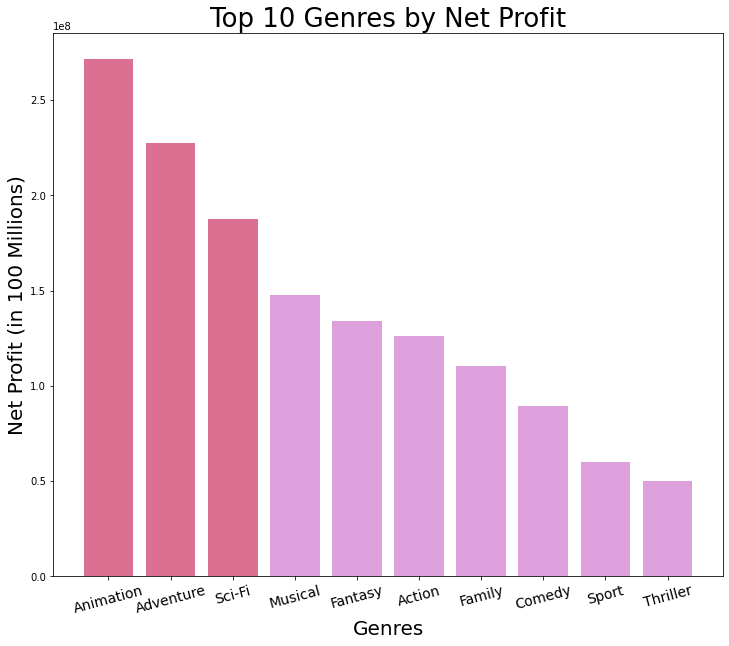

In [654]:
# plotting genres by net_profit

plt.figure(figsize=(12,10))

genres = genre_np.index
net_profit = genre_np.net_profit

plt.bar(range(len(genres)), net_profit, color=['palevioletred', 'palevioletred', 'palevioletred', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum'])
plt.title('Top 10 Genres by Net Profit', fontsize=26)
plt.ylabel('Net Profit (in 100 Millions)', fontsize=20)
plt.xlabel('Genres', fontsize=20)
plt.xticks(range(len(genres)), genres, fontsize=14, rotation=15)

In [640]:
# Creating a new variable and sorting by worldwide_gross
genre_ww = genre_gby.sort_values(['worldwide_gross'], ascending=False).head(10)

In [641]:
# Checking to see if this DataFrame looks the same as genre_np
genre_ww

,production_budget,domestic_gross,worldwide_gross,net_profit,averagerating
genre_list,,,,,
Animation,9.021278e+07,1.299202e+08,3.617968e+08,2.715840e+08,6.578075
Adventure,9.149106e+07,1.129002e+08,3.190709e+08,2.275798e+08,6.445279
Sci-Fi,7.220987e+07,9.514502e+07,2.595184e+08,1.873085e+08,6.168293
Fantasy,7.022444e+07,7.202718e+07,2.044226e+08,1.341981e+08,6.012281
Action,6.520784e+07,7.100792e+07,1.914358e+08,1.262279e+08,6.092846
Musical,3.524762e+07,8.030784e+07,1.827311e+08,1.474834e+08,6.576190
Family,5.154597e+07,6.800699e+07,1.617423e+08,1.101963e+08,6.230405
Comedy,3.701738e+07,5.390026e+07,1.263488e+08,8.933147e+07,6.222262
Sport,2.532873e+07,4.372116e+07,8.525560e+07,5.992687e+07,6.662687


([<matplotlib.axis.XTick at 0x7fd548583cd0>,
 [Text(0, 0, 'Animation'),
  Text(1, 0, 'Adventure'),
  Text(2, 0, 'Sci-Fi'),
  Text(3, 0, 'Fantasy'),
  Text(4, 0, 'Action'),
  Text(5, 0, 'Musical'),
  Text(6, 0, 'Family'),
  Text(7, 0, 'Comedy'),
  Text(8, 0, 'Sport'),
  Text(9, 0, 'Western')])

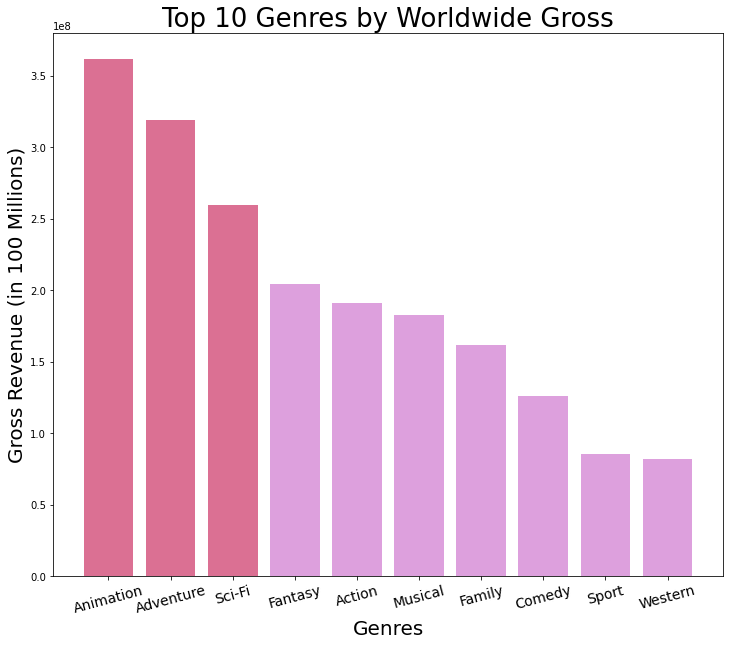

In [655]:
# plotting genres by worldwide_gross

plt.figure(figsize=(12,10))

genres2 = genre_ww.index
worldwide_gross = genre_ww.worldwide_gross
plt.bar(range(len(genres2)), worldwide_gross, color=['palevioletred', 'palevioletred', 'palevioletred', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum'])
plt.title('Top 10 Genres by Worldwide Gross', fontsize=26)
plt.ylabel('Gross Revenue (in 100 Millions)', fontsize=20)
plt.xlabel('Genres', fontsize=20)
plt.xticks(range(len(genres2)), genres2, fontsize=14, rotation=15)

Below, I'm going to go through some similar steps but look at directors instead. First, I'm going to group by a director's name, and then use a sum aggregation.

In [643]:
director_gby = all_df.groupby(['primary_name']).mean()

Now, I'm going to sort the directors by averagerating.

In [644]:
director_sv = director_gby.sort_values(['averagerating'], ascending=False).head(18)

After playing around with the aggregation and sorting values, I realized that when I was sorting directors by averagerating, I was also getting directors who produced unprofitable movies. Even though averagerating still has a positive correlation to worldwide_gross, it isn't as strong of a correlation as production budget. That being said, I'm going to filter the director_sv DataFrame by those with an average net_profit greater than 0.

In [645]:
director_sv_filt = director_sv.loc[director_sv['net_profit'] > 0]

Now that I've grouped by, sorted, and filtered, I'm going to compare my director_sv DataFrame to the results filtered with a net_profit > 0.

In [646]:
director_sv_filt.head(10)

,production_budget,domestic_gross,worldwide_gross,net_profit,averagerating
primary_name,,,,,
Ron Yassen,6250000.0,18594333.5,28500000.0,22250000.0,9.3
Ricardo Martinez,3000000.0,1803064.0,4495262.0,1495262.0,9.2
Pete Middleton,48000000.0,124107476.0,208300000.0,160300000.0,9.2
Angel Manuel Soto,11000000.0,13110448.0,19947280.0,8947280.0,9.0
Suman Upreti,14000000.0,11242801.0,20597806.0,6597806.0,8.9
Giriraj Ghimire,14000000.0,11242801.0,20597806.0,6597806.0,8.9
Milan Chams,14000000.0,11242801.0,20597806.0,6597806.0,8.9
Indra Gunawan,28000000.0,50255310.0,77477297.0,49477297.0,8.8
Mike Erickson,3000000.0,11977130.0,16553285.0,13553285.0,8.8


In [647]:
# Taking a look at the new DataFrame
director_sv_filt.head(10)

,production_budget,domestic_gross,worldwide_gross,net_profit,averagerating
primary_name,,,,,
Ron Yassen,6250000.0,18594333.5,28500000.0,22250000.0,9.3
Ricardo Martinez,3000000.0,1803064.0,4495262.0,1495262.0,9.2
Pete Middleton,48000000.0,124107476.0,208300000.0,160300000.0,9.2
Angel Manuel Soto,11000000.0,13110448.0,19947280.0,8947280.0,9.0
Suman Upreti,14000000.0,11242801.0,20597806.0,6597806.0,8.9
Giriraj Ghimire,14000000.0,11242801.0,20597806.0,6597806.0,8.9
Milan Chams,14000000.0,11242801.0,20597806.0,6597806.0,8.9
Indra Gunawan,28000000.0,50255310.0,77477297.0,49477297.0,8.8
Mike Erickson,3000000.0,11977130.0,16553285.0,13553285.0,8.8


Now I can see some more directors who have had profitable movies without really having to sacrifice anything in averagerating.

Now that I've created the variable, I also want to plot this into a bar graph.

(array([ 0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

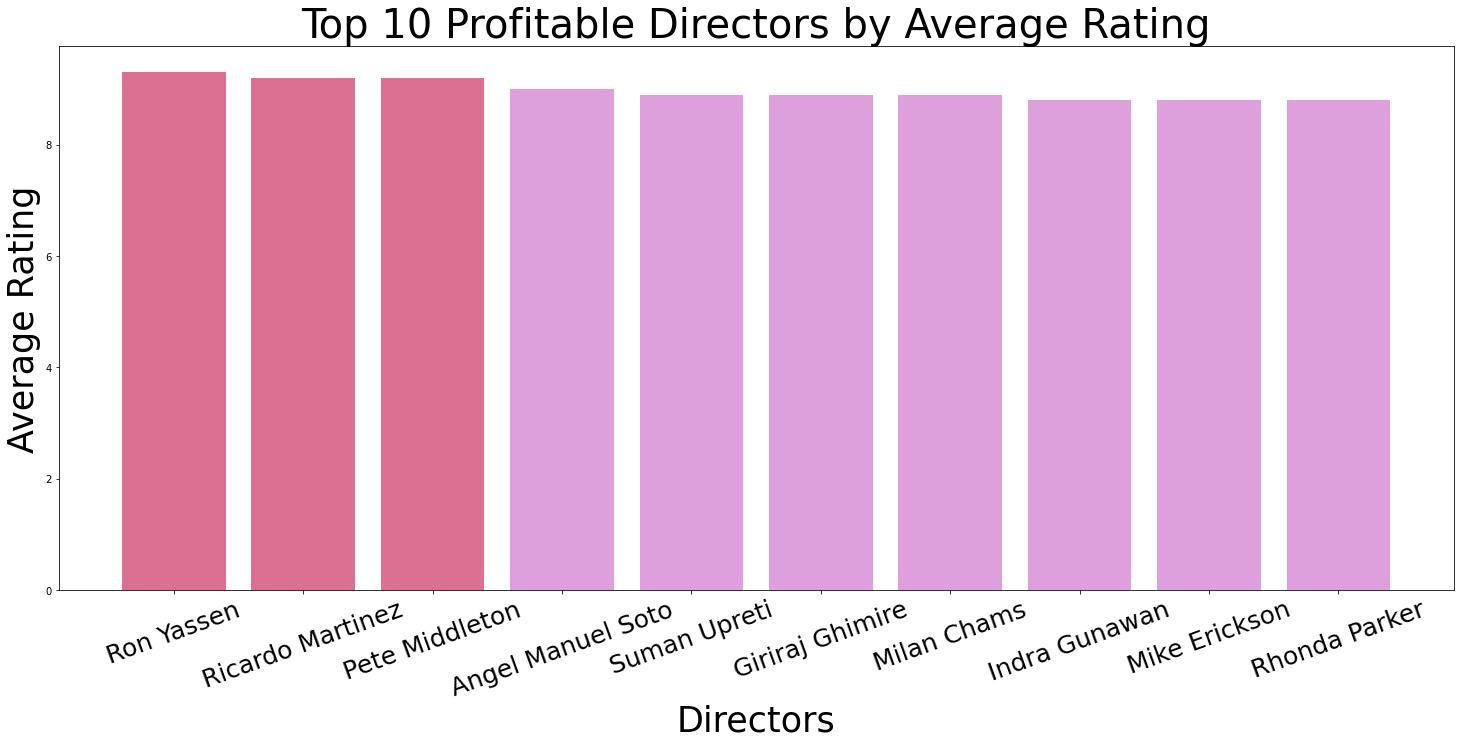

In [656]:
plt.figure(figsize=(25, 10))

directors = director_sv_filt.index
rating = director_sv_filt.averagerating
plt.bar(range(len(directors)), rating, color=['palevioletred', 'palevioletred', 'palevioletred', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum'])

plt.title('Top 10 Profitable Directors by Average Rating', fontsize=40)
plt.ylabel('Average Rating', fontsize=35)
plt.xlabel('Directors', fontsize=35)
plt.xticks(range(len(directors)), directors, fontsize=25, rotation=20)
plt.yticks()

After looking at directors by averagerating, I want to sort them by net profit as well to see how much things change.

In [649]:
# Sorting directors by net_profit
directors_np = director_gby.sort_values('net_profit', ascending=False).head(10)

In [650]:
# Looking at the new DataFrame
directors_np.head(10)

,production_budget,domestic_gross,worldwide_gross,net_profit,averagerating
primary_name,,,,,
Pete Meads,200000000.0,659363944.0,2.208208e+09,2.008208e+09,6.200000
Kevin Lincoln,200000000.0,659363944.0,2.208208e+09,2.008208e+09,6.200000
Jennifer Lee,150000000.0,400738009.0,1.272470e+09,1.122470e+09,7.500000
Adam Green,150000000.0,400738009.0,1.272470e+09,1.122470e+09,6.200000
Chris Buck,150000000.0,400738009.0,1.272470e+09,1.122470e+09,7.500000
Joe Russo,240000000.0,448882263.0,1.300869e+09,1.060869e+09,8.033333
Anthony Russo,240000000.0,448882263.0,1.300869e+09,1.060869e+09,8.033333
Kyle Balda,74500000.0,300335035.0,1.097532e+09,1.023032e+09,6.350000
Eric Guillon,75000000.0,264624300.0,1.034728e+09,9.597278e+08,6.300000


(array([0.00e+00, 2.50e+08, 5.00e+08, 7.50e+08, 1.00e+09, 1.25e+09,
        1.50e+09, 1.75e+09, 2.00e+09, 2.25e+09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

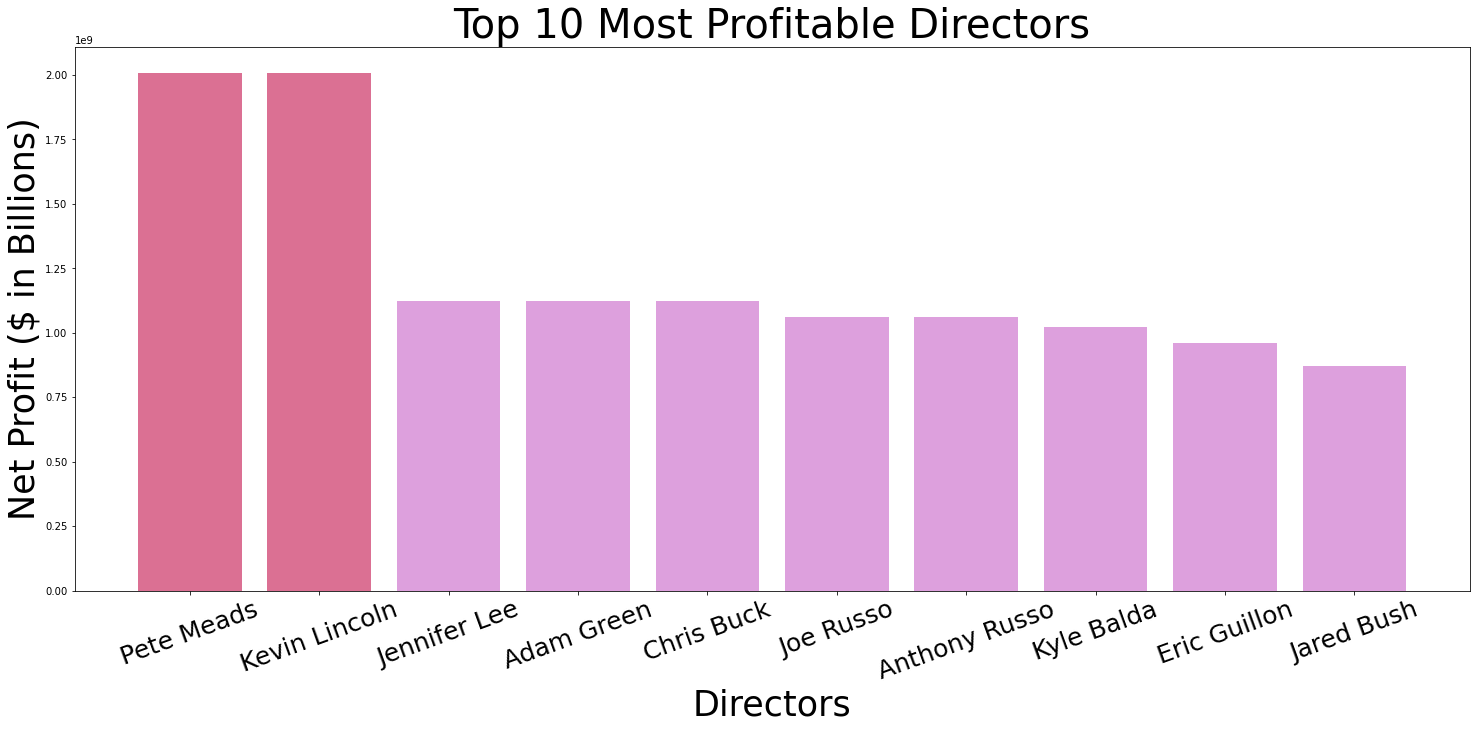

In [658]:
# Plotting directors by net profit
plt.figure(figsize=(25, 10))

directors = directors_np.index
net_profit = directors_np.net_profit
plt.bar(range(len(directors)), net_profit, color=['palevioletred', 'palevioletred', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum', 'plum'])

plt.title('Top 10 Most Profitable Directors', fontsize=40)
plt.ylabel('Net Profit ($ in Billions)', fontsize=35)
plt.xlabel('Directors', fontsize=35)
plt.xticks(range(len(directors)), directors, fontsize=25, rotation=20)
plt.yticks()

At first, it seems surprising that these Directors have the exact same net profit, but it's actually because these directors have worked on successful movies together.

One of the major things I'm comparing as well is how net profit is impacted by production budget. I'm going to use a scatter plot for this because there are so many data points.

Text(0, 0.5, 'Net Profit(in Billions)')

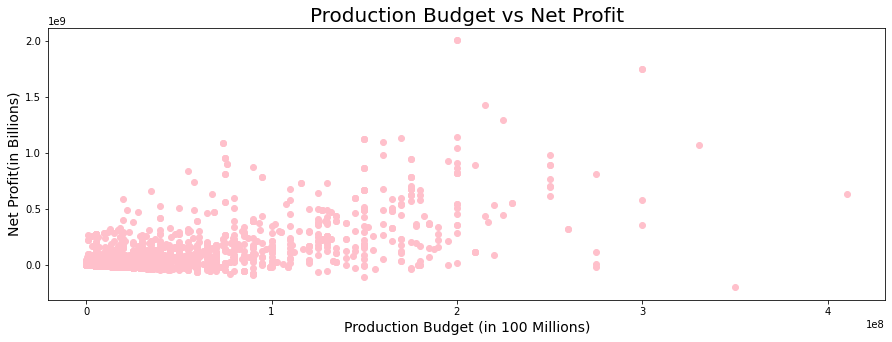

In [652]:
#Set up plot
fig, ax = plt.subplots(figsize=(15,5))
                       
#Plot Net Profit vs Production Budget
ax.scatter(all_df['production_budget'], all_df['net_profit'], alpha=1.0, color='pink')
ax.set_title('Production Budget vs Net Profit', fontsize=20)
ax.set_xlabel('Production Budget (in 100 Millions)', fontsize=14)
ax.set_ylabel('Net Profit(in Billions)', fontsize=14)

***

# Evaluation

Based on these visuals, I am cofident that this could be applied to a larger dataset and generalize that as well. If I were to do this analysis again, I would do my best to get more current data and make sure I got data on all of the best movies possible. Because of the way some of the DataFrames had to be joined, some movies had to be excluded (i.e. Avatar). This analysis could also be made more efficiently by using functions, and be a more thorough evaluation by going through more aspects like actors, run time, release date, and screenwriters. In the future I would go further into analysis by grouping production budget into buckets, along with gross or net profit.

***

# Conclusions
## *Recommendations*

### Genre

- *Animation*
- *Adventure*
- *Sci-fi*

There are many types of animation that Microsoft could pursue, but it would definitely limit Microsoft to a demographic who likes to watch animated movies. Adventure and Sci-fi are very similar in that sense, where most people don't like certain genres. However, these three genres are very popular and they're also the most profitable. Since Microsoft doesn't have the first mover advantage in the film industry, the biggest challenge will be creating original ideas.

### Directors

- *Ron Yassen* 
- *Ricardo Martinez*
- *Pete Middleton*

Ron Yassen, Ricardo Martinez, and Pete Middleton are all great directors with top ratings and profitable movies. Average rating does have a positive correlation to net profit, but it isn't as strong of a correlation as production budget. That being said, I also wanted to take a look at directors with the highest Net Profit to remain consistent with the genre analysis. 

- *Pete Meads*
- *Kevin Lincoln*

Pete Meads and Kevin Lincoln are two of the best directors when considering net profit. Although their ratings aren't as high as other directors, that is likely because their main genre is Animation, and like I said before, Animation is not for everyone. 

This analysis of Directors provides Microsoft with some options. If Microsoft's priority is net profit, then they should consider creating an animated film with animation directors. However, if that isn't Microsoft's concern for their first movie, and the company would rather leave a lasting impression with a high rating, then Microsoft should consider another top genre like Adventure or Sci-Fi and have it be directed by Ron Yassen, Ricardo Martinez, or Pete Middleton. 

### Production Budget

- Production Budget > $100 Million

Microsoft should expect to allocate at least 100 million dollars into the film's production budget. As seen in the scatter plot, there are many profitable movies that have spent 100 million dollars on production and have easily doubled their net profit.


## *Limitations and Lessons Learned*

**Limitations**

This data is not the newest data. At the time of this analysis, it's Fall 2022, but a lot of this data is as old as 2019. A lot of major movies such as Avatar have been excluded from this analysis because there wasn't enough data to perform the analysis. In the future, I would perform webscraping to get more recent, accurate data that is more well-rounded of the current film industry environment. I would also apply certain filters to directors to make sure they are in the genre that I recommended Microsoft create.

**Lessons Learned**

In the future, I would create more functions throughout the analysis to reduce repition and increase ease of reproduction. I would also be sure to look at all of the files before deciding how I wanted to conduct my analysis. Not only that, but I would look at which DataFrames have primary keys, so I didn't have to join on something other than a primary key. In the future, if I don't know that much about the data, I would confirm that it makes sense. For example, if I had a person in my DataFrame and I was recommending them as a director, I would verify that they have in fact directed movies before.

***